In [1]:
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import collections

import nengo_loihi

import _init_paths

from configs.exp_configs import tf_exp_cfg as tf_cfg, nengo_dl_cfg as ndl_cfg
from utils.base_utils.data_prep_utils import get_batches_of_exp_dataset, get_exp_dataset
from utils.base_utils.exp_utils import get_shuffled_lists_in_unison
from utils.nengo_dl_utils import get_nengo_dl_model

In [2]:
ndl_model, ngo_probes_lst = get_nengo_dl_model(
    (32, 32, 3), tf_cfg, ndl_cfg, mode="test", num_clss=10,
    max_to_avg_pool=False, include_layer_probes=True, channels_first=False)

/homes/rgaurav/nxsdk_1_nengo_loihi/lib/python3.8/site-packages/nengo_dl/converter.py:324: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  warnings.warn(


In [3]:
probe = ngo_probes_lst[1:-1][0]
print(probe)

<Probe of 'output' of <Neurons of <Ensemble "conv2d_2.0">>>


In [4]:
probe.obj.ensemble.label

'conv2d_2.0'

In [3]:
train_x, train_y, _, _ = get_exp_dataset(tf_cfg["dataset"])

In [5]:
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1, rotation_range=20,
    horizontal_flip=True, data_format="channels_first")
train_idg.fit(train_x, seed=0)

In [3]:
train_batches = get_batches_of_exp_dataset(ndl_cfg, ndl_model, ngo_probes_lst, is_test=False)

# ###############################################################

In [2]:
inp = tf.keras.Input(shape=(1, 28, 28), name="input")

to_spikes = tf.keras.layers.Conv2D(
  filters=3, # 3 RGB Neurons per pixel.
  kernel_size=(1, 1), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, # Default is True.
  data_format="channels_first", name="to-spikes")(inp)

################################ ON-CHIP LAYERS ##################################
conv0 = tf.keras.layers.Conv2D(
  filters=8, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, data_format="channels_first", name="conv0")(to_spikes)

avgp0 = tf.keras.layers.AveragePooling2D(
  pool_size=(2, 2), padding="valid", data_format="channels_first",
  name="AvgPool0")(conv0)

conv1 = tf.keras.layers.Conv2D(
  filters=16, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,
  use_bias=False, data_format="channels_first", name="conv1")(avgp0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)
dense0 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name="dense0")(flatten)

In [3]:
dense1 = tf.keras.layers.Dense(10, name="dense1")(dense0)
model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 28, 28)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 3, 28, 28)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 8, 26, 26)         216       
_________________________________________________________________
AvgPool0 (AveragePooling2D)  (None, 8, 13, 13)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 11, 11)        1152      
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense0 (Dense)               (None, 64)                123968

In [7]:
nengo_converter = nengo_dl.Converter(
    model,
    scale_firing_rates=400,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    synapse=0.005,
)
net = nengo_converter.net

In [8]:
with net:
    nengo_loihi.add_params(net)  # allow on_chip to be set
    # Both of the following lines works.
    #net.config[nengo_converter.layers[to_spikes].ensemble].on_chip = False
    net.config[nengo_converter.layers[nengo_converter.model.layers[1]].ensemble].on_chip = False

In [12]:
loihi_sim = nengo_loihi.Simulator(net, target="sim", remove_passthrough=False)

BuildError: Conv2D transforms not supported for off-chip to on-chip connections where `pre` is not a Neurons object.

In [5]:
mp_lyr_otpt = np.load("/home/rgaurav/projects/def-anarayan/rgaurav/spiking_investigation/experiment_outputs/cifar10/"
                      "model_1/ndl_train_test_results/ndl_test_only_results/sim_lyr_probes_otpt.npy", allow_pickle=True)

In [6]:
ti_0_mp_output = mp_lyr_otpt.item()["max_pooling2d"][0]

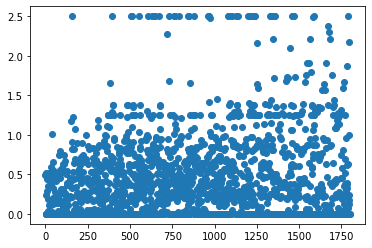

In [18]:
ti_mp_output = mp_lyr_otpt.item()["max_pooling2d"][0]
plt.scatter(np.arange(0, 1800), np.mean(ti_mp_output[-10:, :], axis=0))

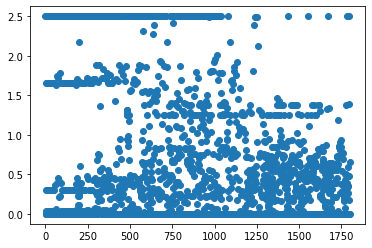

In [19]:
ti_mp_output = mp_lyr_otpt.item()["max_pooling2d"][1]
plt.scatter(np.arange(0, 1800), np.mean(ti_mp_output[-10:, :], axis=0))